In [34]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset
from transforms import BrainMRITransforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob

from torchvision import transforms

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score


seed = 37
pd.set_option('display.max_colwidth', None)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
# def seed_everything(seed=37):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
# seed_everything()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Currently using "{device.upper()}" device.')

In [37]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
EPOCHS = 100
NUM_CLASSES = 1  

In [38]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
        ])

# valid_transforms = A.Compose([
#                       A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
#                       A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
#                       ToTensorV2(p=1.0),
#                       ], p=1.0)

# invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
#                                   std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
#                       A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
#                                   std=[ 1., 1., 1. ], max_pixel_value=1.0),
#                       ], p=1.0)

# def inverse_transforms(tensor):
#     if tensor.size(0) == 1 and len(tensor.shape) == 4:
#         tensor.squeeze_(0)
#     sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
#     image = invTrans(**sample)["image"]

#     return image

In [39]:
# DATASET_PATH = '../datasets/tumor_segs/kaggle_3m'

In [40]:
# mask = Image.open(f"{DATASET_PATH}/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif") 
# mask = np.array(mask)[..., np.newaxis]
# mask = np.repeat(mask, 3, axis=-1)

# image = Image.open(f"{DATASET_PATH}/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif")
# image = np.array(image)

# # image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

# plt.imshow(mask)
# plt.show()

In [41]:
# all_paths = glob(f"{DATASET_PATH}/*/*.tif")
# images_paths = sorted([path for path in all_paths if "mask" not in path])
# masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
# masks_paths = [path + "_mask.tif" for path in masks_paths]
# del all_paths; gc.collect()

In [42]:
# data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

# x_train, x_valid = train_test_split(data, train_size=0.8, shuffle=True, random_state=seed)
# x_test, x_valid = train_test_split(x_valid, train_size=0.5, shuffle=True, random_state=seed)
# x_train = x_train.reset_index(drop=True)
# x_valid = x_valid.reset_index(drop=True)
# x_test = x_test.reset_index(drop=True)

# print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

In [43]:
# class SegDataset(Dataset):
#     def __init__(self, data, transforms):
#         self.data = data
#         self.transforms = transforms
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, ix):
#         row = self.data.loc[ix].squeeze()
#         image = Image.open(row["image"])
#         image = np.array(image)
        
#         mask = Image.open(row["mask"])
#         mask = np.array(mask)
        
#         mask = np.where(mask > 127, 255, 0)
        
#         sample = {"image": image, "mask": mask}
#         sample = self.transforms(**sample)
        
#         image, mask = sample["image"], sample["mask"]
#         mask = mask[None, ...]
        
#         return image, mask / 255.
    
#     def collate_fn(self, batch):
#         images, masks = list(zip(*batch))
#         images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
#         images, masks = [torch.cat(tensors) for tensors in [images, masks]]
#         return images, masks

In [44]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):

        image = cv2.imread(self.data.iloc[ix, 0]) / 255.0
        mask = cv2.imread(self.data.iloc[ix, 1], cv2.IMREAD_GRAYSCALE) / 255.0
        
        mask = np.where(mask >= 0.5, 1., 0.)

        image = valid_transforms(image)
        mask = valid_transforms(mask)
    
        return image, mask 

In [45]:
# train_ds = SegDataset(x_train,train_transforms)
# valid_ds = SegDataset(x_valid,valid_transforms)
# test_ds = SegDataset(x_test,valid_transforms)

# train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
# valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_ds.collate_fn)

In [46]:
# x_train.sample(5)

In [47]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

# transform_ = BrainMRITransforms()

train_data = SegDataset(train_df, transforms= train_transforms)
val_data = SegDataset(val_df, transforms= valid_transforms)
test_data = SegDataset(test_df, transforms= valid_transforms)

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = BATCH_SIZE , shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE , shuffle = False)


In [48]:
print(f"Train size: {train_df.shape[0]}, validation size: {val_df.shape[0]}, test size: {test_df.shape[0]}")

Train size: 3143, validation size: 393, test size: 393


In [49]:
# https://github.com/FrancescoSaverioZuppichini/SegFormer

class LayerNorm2d(nn.LayerNorm):
    """ swap channel dim, apply layer norm and swap back: see https://github.com/pytorch/pytorch/issues/71465 """
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x
    
class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super(OverlapPatchMerging, self).__init__(
                                        nn.Conv2d(
                                            in_channels,
                                            out_channels,
                                            kernel_size=patch_size,
                                            stride=overlap_size,
                                            padding=patch_size // 2,
                                            bias=False
                                        ),
                                        LayerNorm2d(out_channels)
                                    )

In [50]:
# positional encoding eliminated as for original paper: https://arxiv.org/pdf/2105.15203.pdf

class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V 
        x = rearrange(x, "b c h w -> b (h w) c")  # Q
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out
    
# transformer FFN block, here fully convolutional

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # linear layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),
            # linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [51]:
class ResidualAdd(nn.Module):
    """ A layer that helps to add&norm MHA and FFN outputs """
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    """ Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly """
    def __init__(
                self,
                channels: int,
                reduction_ratio: int = 1,
                num_heads: int = 8,
                mlp_expansion: int = 4,
                drop_path_prob: float = .0
            ):
        super(SegFormerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")  # https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html
                )
            ),
        )

In [52]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [53]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk
        
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )
        
    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [54]:
# decoder 
class SegFormerDecoderBlock(nn.Sequential):
    """ upsample """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )
        
class SegFormerDecoder(nn.Module):
    """ takes a list of features and returns a list of new features with the same spatial size and channels """
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )
    
    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [55]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)  # paper
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)  # concatenate all features obtained before (they have same spatial dims and channels)
        x = self.fuse(x)  # conv and normalize
        x = self.predict(x)  # get final feature map(s)
        return x

In [56]:
# final model: encoder -> decoder -> head

class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super(SegFormer, self).__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])  # in the reverse order
        segmentation = self.head(features)
        return segmentation

In [57]:
# check model
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

segmentation = segformer(torch.randn((1, 3, 256, 256)))
segmentation.shape # torch.Size([1, 2, 56, 56])

torch.Size([1, 1, 64, 64])

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of parameters in the model
num_params = count_parameters(segformer)
print(f"Total number of parameters: {num_params:,}")

Total number of parameters: 17,782,913


In [59]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5):
    model.train()
    images, masks = data
    
    optimizer.zero_grad()
    out = model(images)  # [B, 1, 56, 56]
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]
    
    loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones

    loss.backward()
    optimizer.step()
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean()  # binary accuracy
    
    return loss.item(), mask_accuracy.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5):
    model.eval()
    images, masks = data
    out = model(images)
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    
    loss = criterion(out, masks)
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean() 
    
    return loss.item(), mask_accuracy.item()

@torch.no_grad()
def test_plot(model):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
    
    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask = np.repeat(mask, 3, axis=-1)
    
    # masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    out = model(inputs)
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= 0.5, 1, 0)
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    # out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(mask)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [60]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [61]:
# Step 1: Instantiate the model
model = nn.DataParallel(SegFormer(
                in_channels=3,
                widths=[64, 128, 256, 512],
                depths=[3, 4, 6, 3],
                all_num_heads=[1, 2, 4, 8],
                patch_sizes=[7, 3, 3, 3],
                overlap_sizes=[4, 2, 2, 2],
                reduction_ratios=[8, 4, 2, 1],
                mlp_expansions=[4, 4, 4, 4],
                decoder_channels=256,
                scale_factors=[8, 4, 2, 1],
                num_classes=NUM_CLASSES,
)).to(device)

criterion = nn.BCEWithLogitsLoss()  # add pos_weight? tensor of size [2,]
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=8)

In [62]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 17782913
Trainable parameters: 17782913


In [63]:
# Load weights for parallel training
state_dict = torch.load('segformer_v2_weights.pth', map_location=device)
# Remove the 'module.' prefix from keys if present
# state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Load state dict
model.load_state_dict(state_dict)
model.eval()

DataParallel(
  (module): SegFormer(
    (encoder): SegFormerEncoder(
      (stages): ModuleList(
        (0): SegFormerEncoderStage(
          (overlap_patch_merge): OverlapPatchMerging(
            (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
            (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
          )
          (blocks): Sequential(
            (0): SegFormerEncoderBlock(
              (0): ResidualAdd(
                (fn): Sequential(
                  (0): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                  (1): EfficientMultiHeadAttention(
                    (reducer): Sequential(
                      (0): Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
                      (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                    )
                    (att): MultiheadAttention(
                      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=

In [64]:
# ### Unsure how to get size due to how it is loaded
# # Just need to access the weights from model


size_model = 0
for param in state_dict.values():
    if param.is_floating_point():
        size_model += param.numel() * torch.finfo(param.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")


model size: 569069664 / bit | 71.13 / MB


In [65]:
def visualize_sample(image, pred_mask, true_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot image
    axes[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot predicted mask
    axes[1].imshow(pred_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Plot true mask
    axes[2].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[2].set_title('True Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

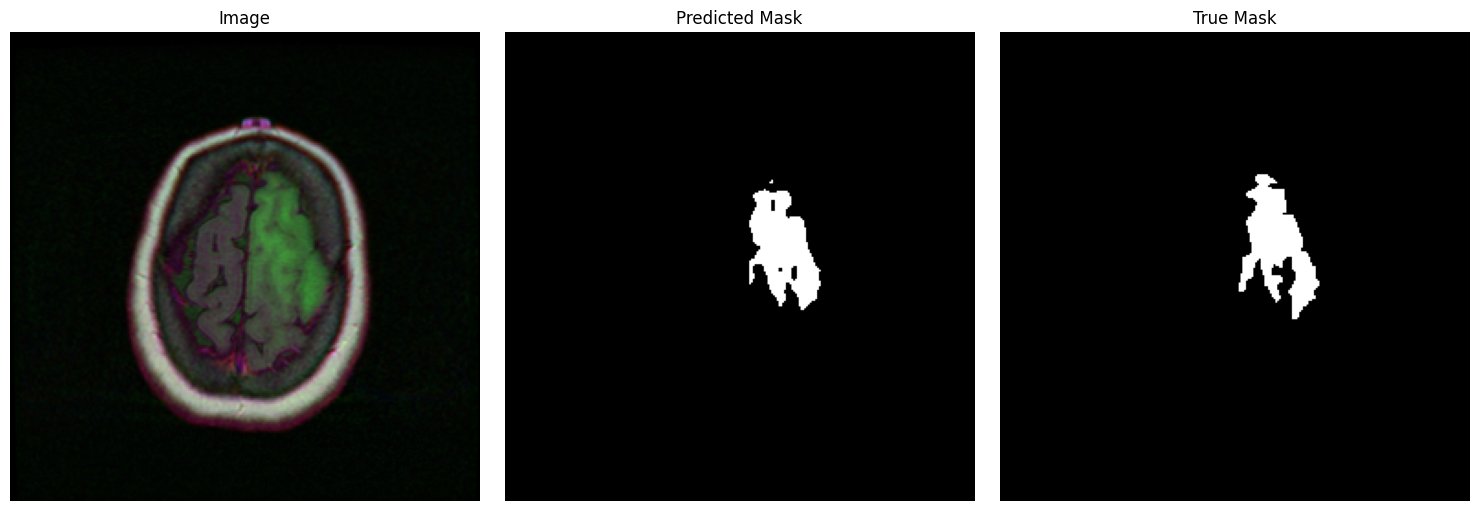

iou: 0.7403528094291687
dice: 0.8508077263832092


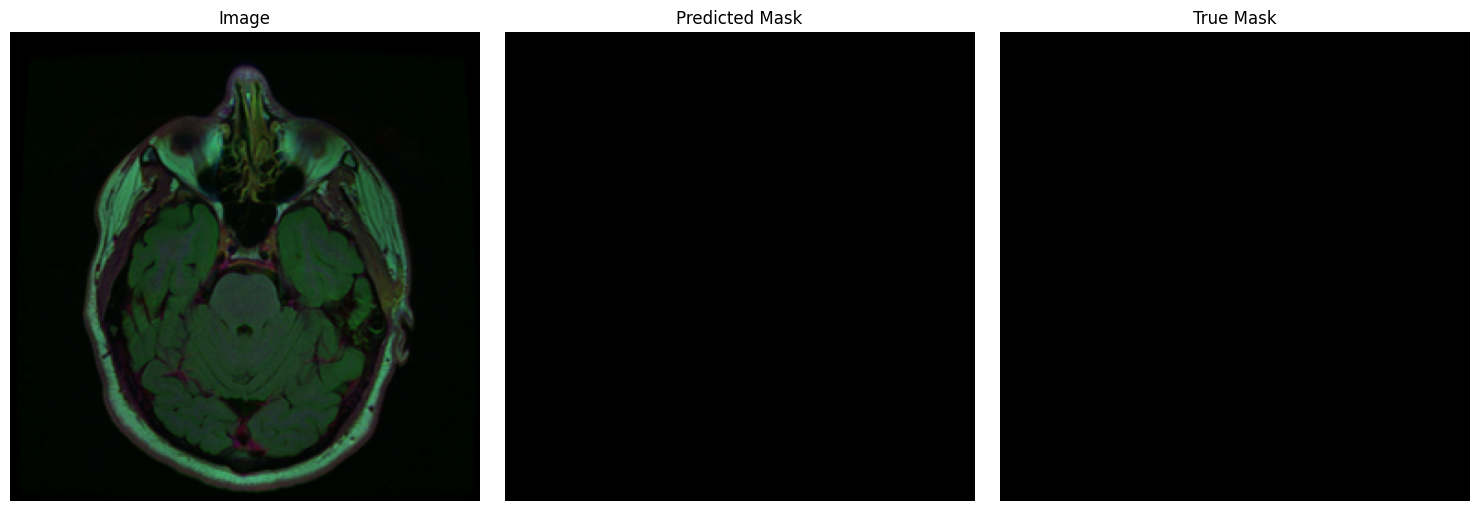

iou: 0.0
dice: nan


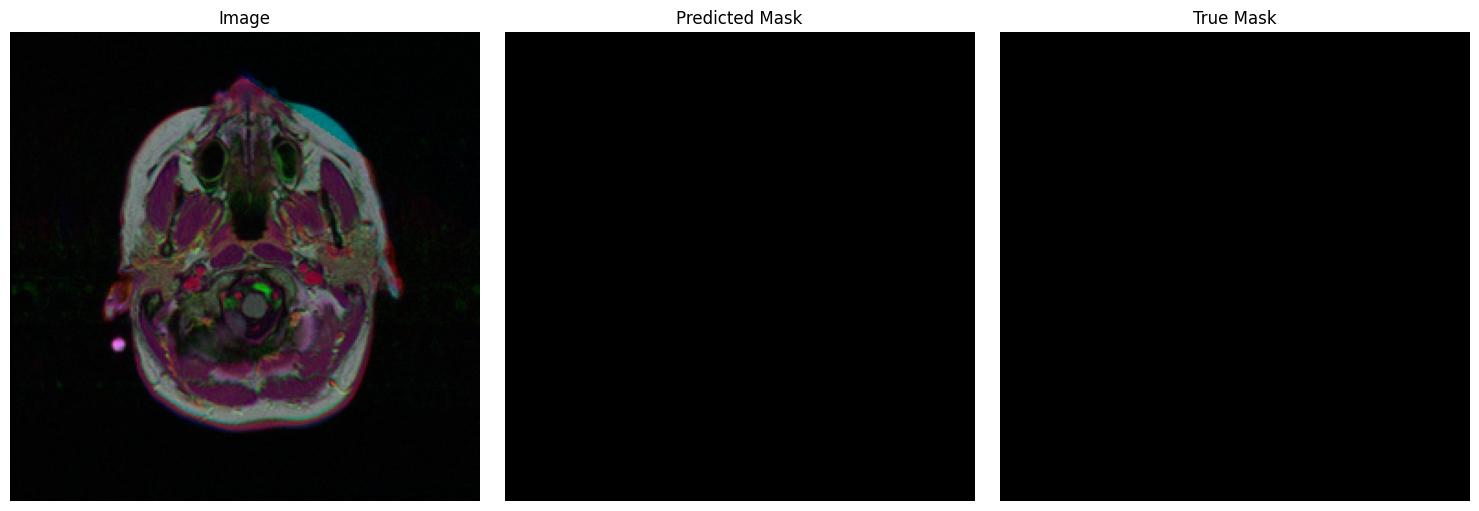

iou: 0.0
dice: nan


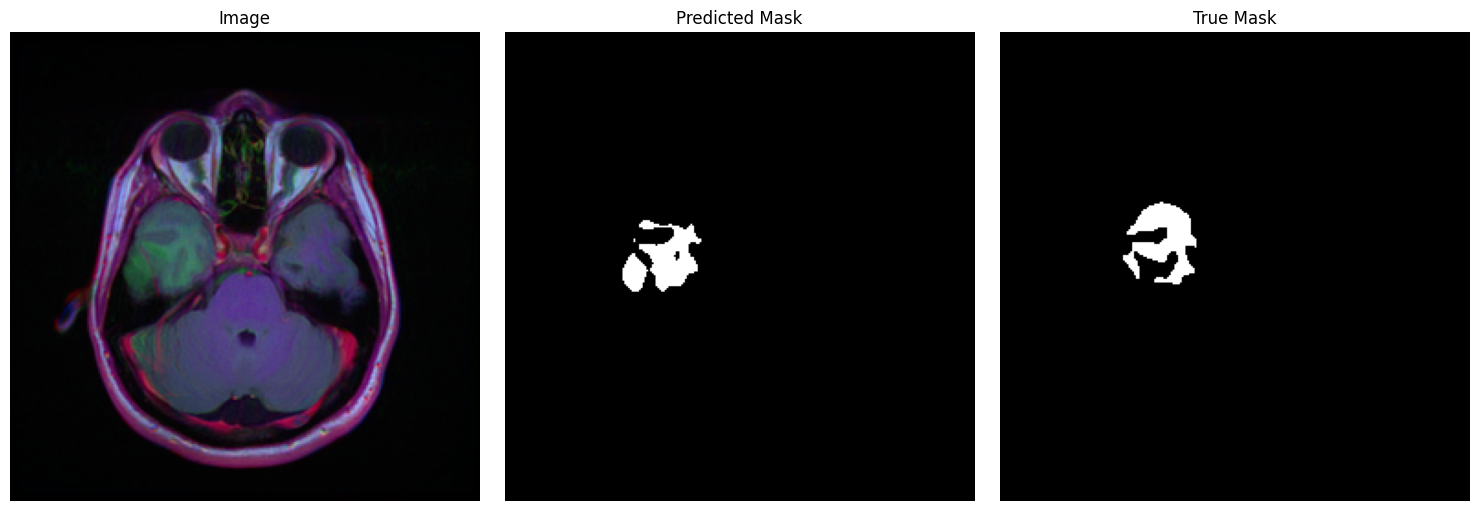

iou: 0.43423137068748474
dice: 0.6055248379707336


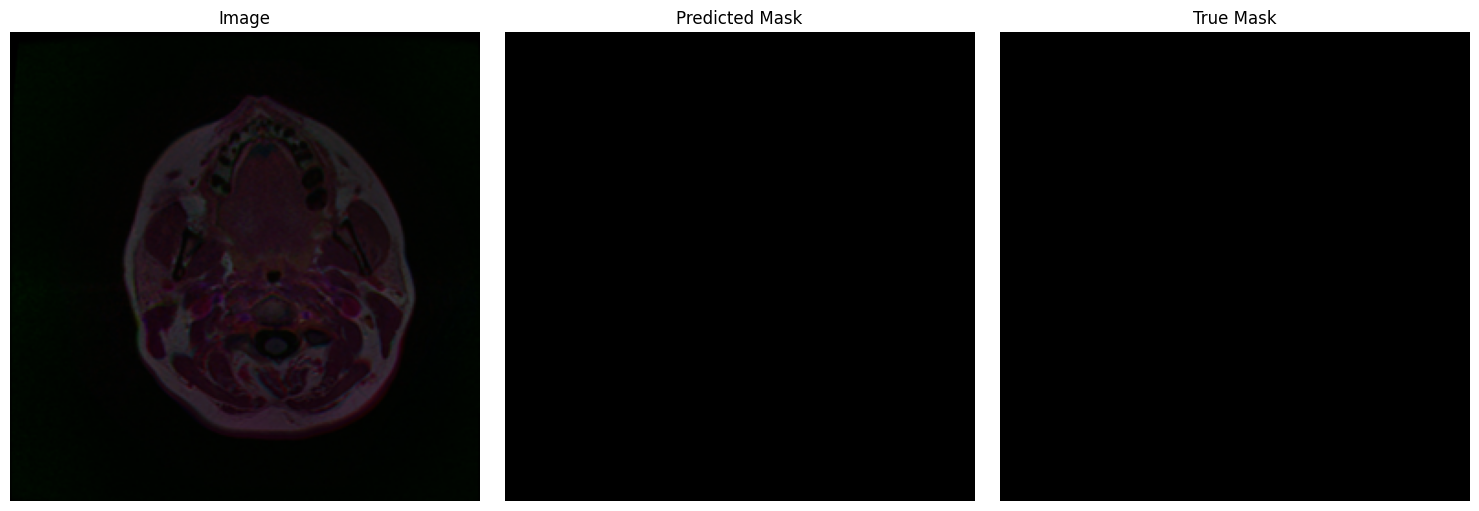

iou: 0.0
dice: nan


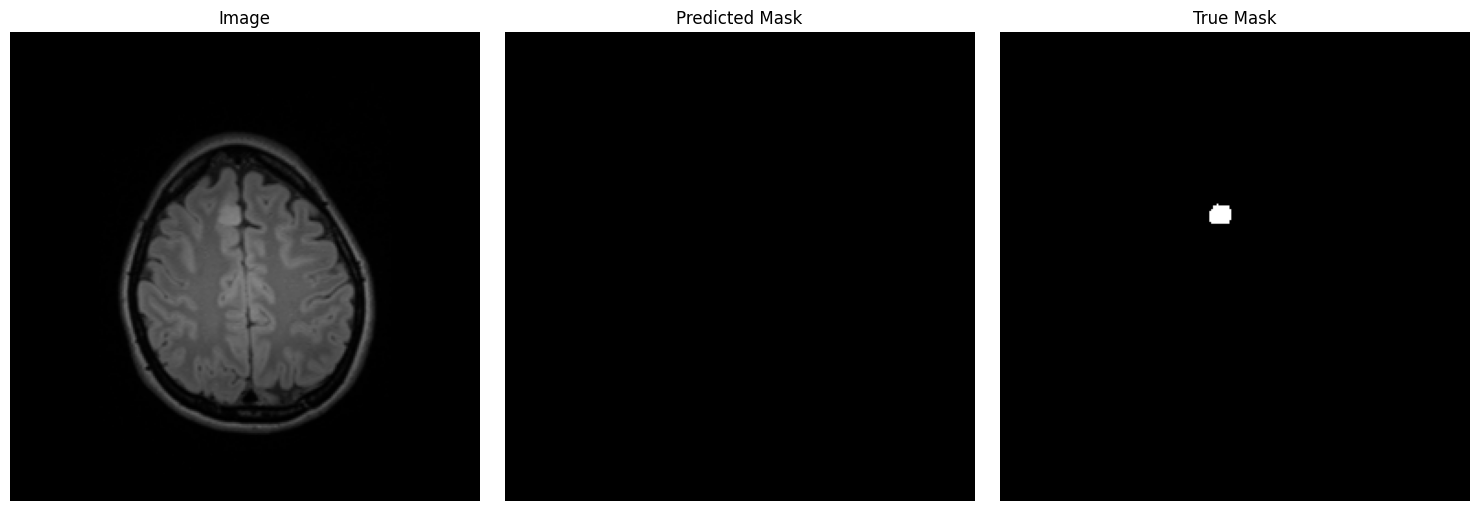

iou: 0.0
dice: 0.0


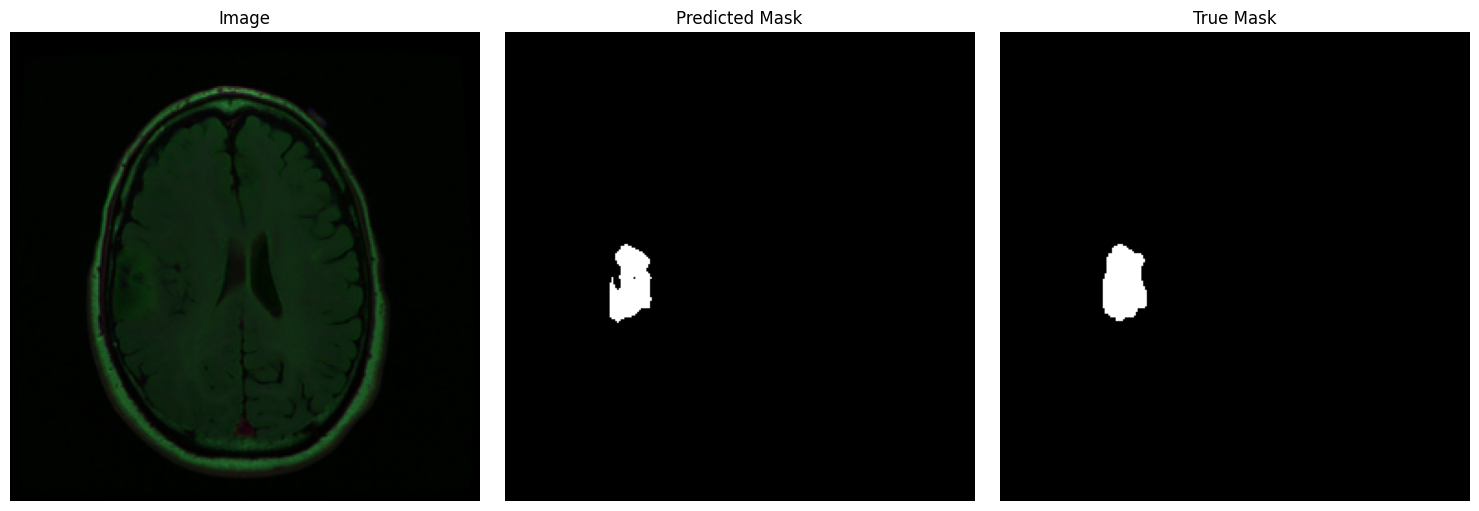

iou: 0.8091133236885071
dice: 0.8944860696792603


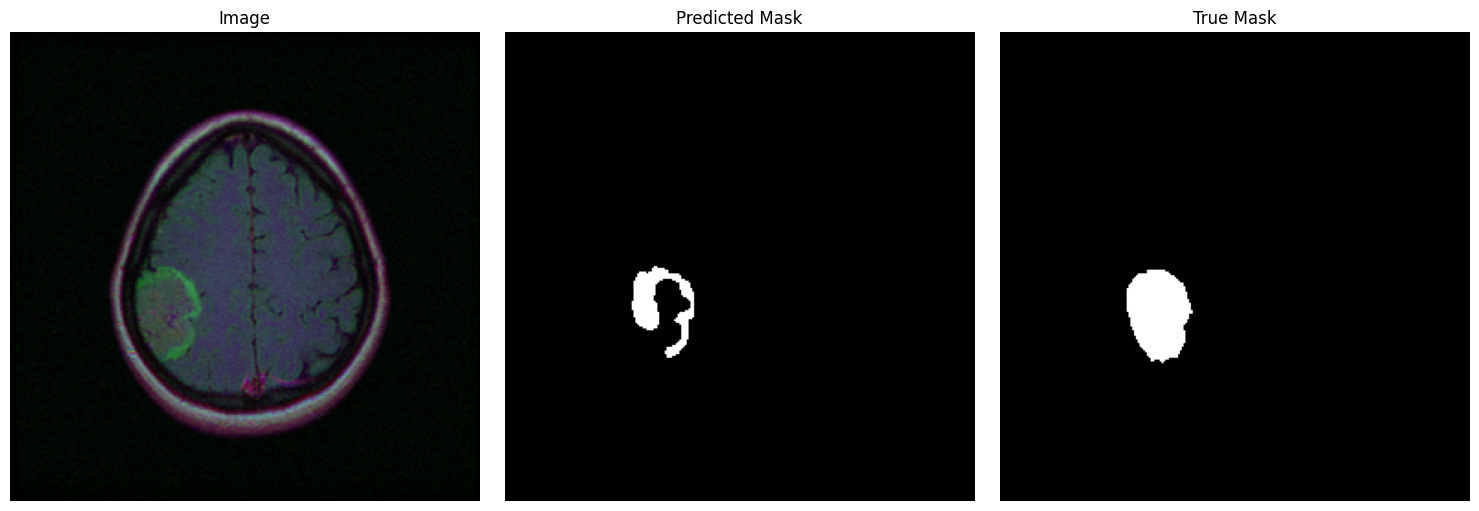

iou: 0.46816208958625793
dice: 0.6377525925636292


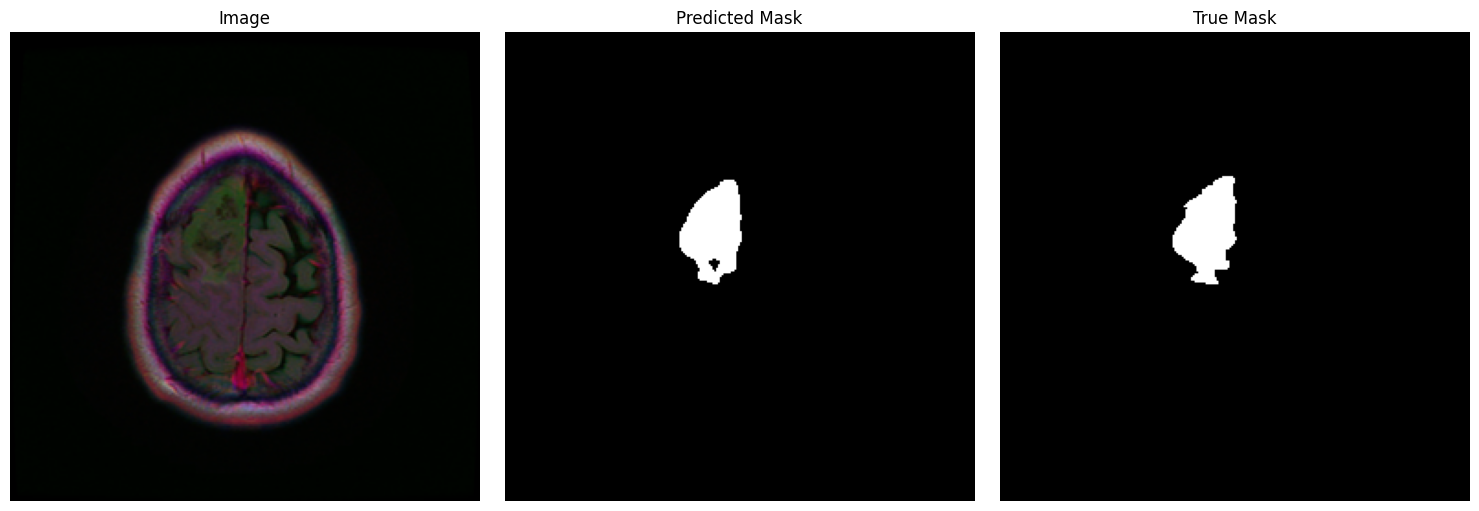

iou: 0.8768577575683594
dice: 0.9343891143798828


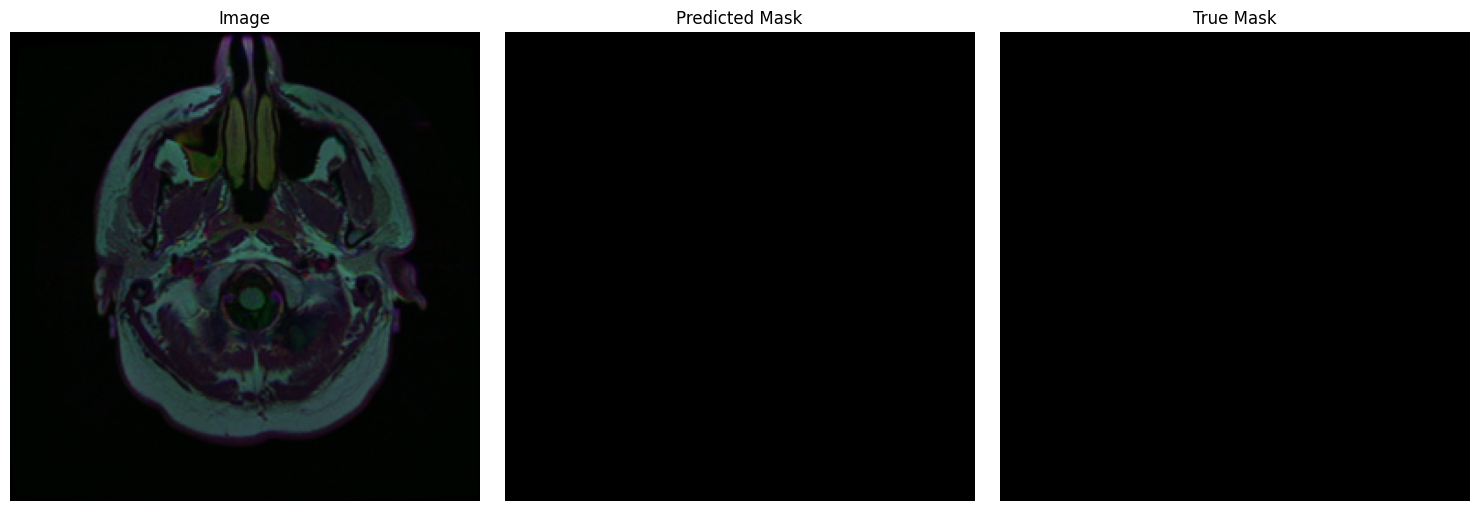

iou: 0.0
dice: nan


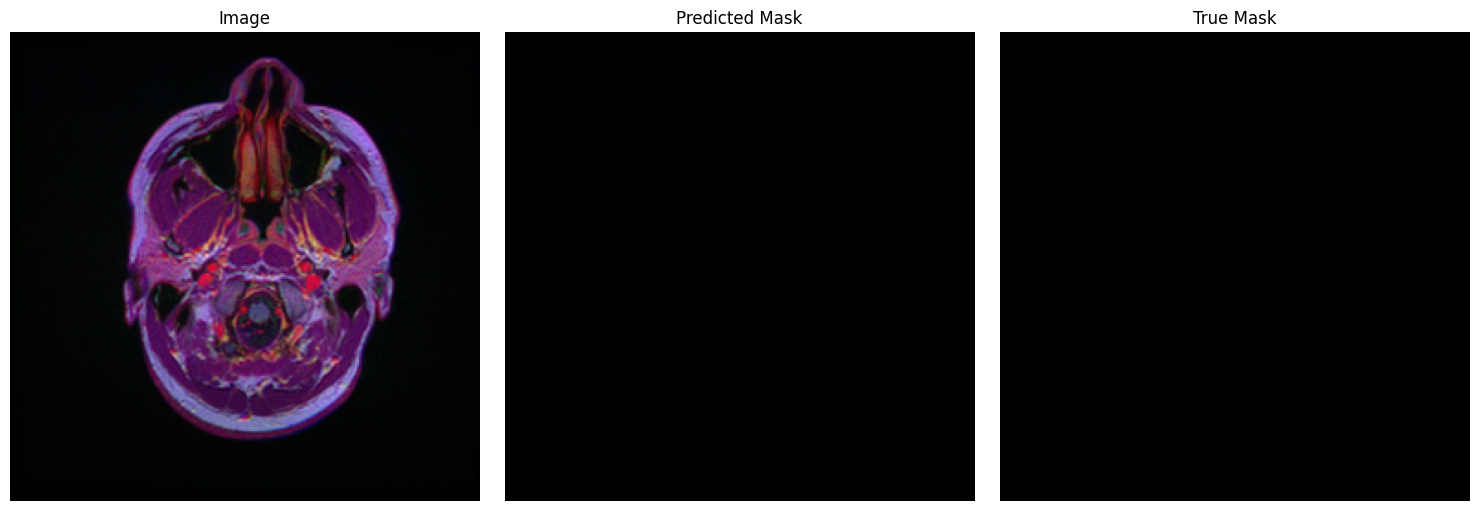

iou: 0.0
dice: nan


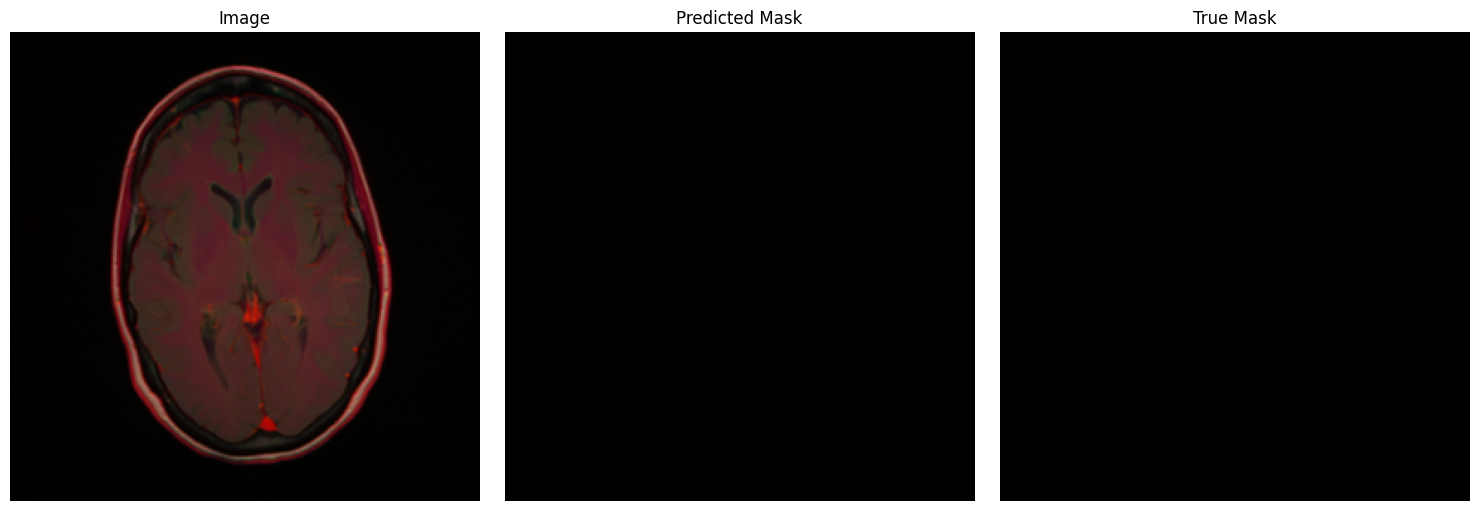

iou: 0.0
dice: nan


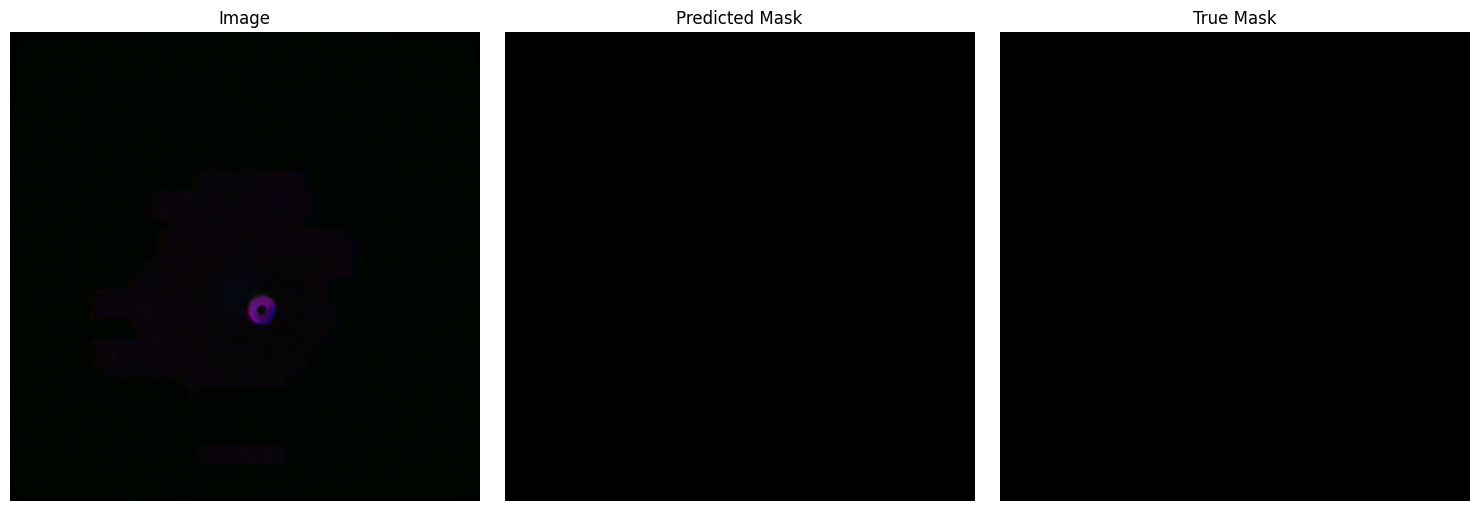

iou: 0.0
dice: nan


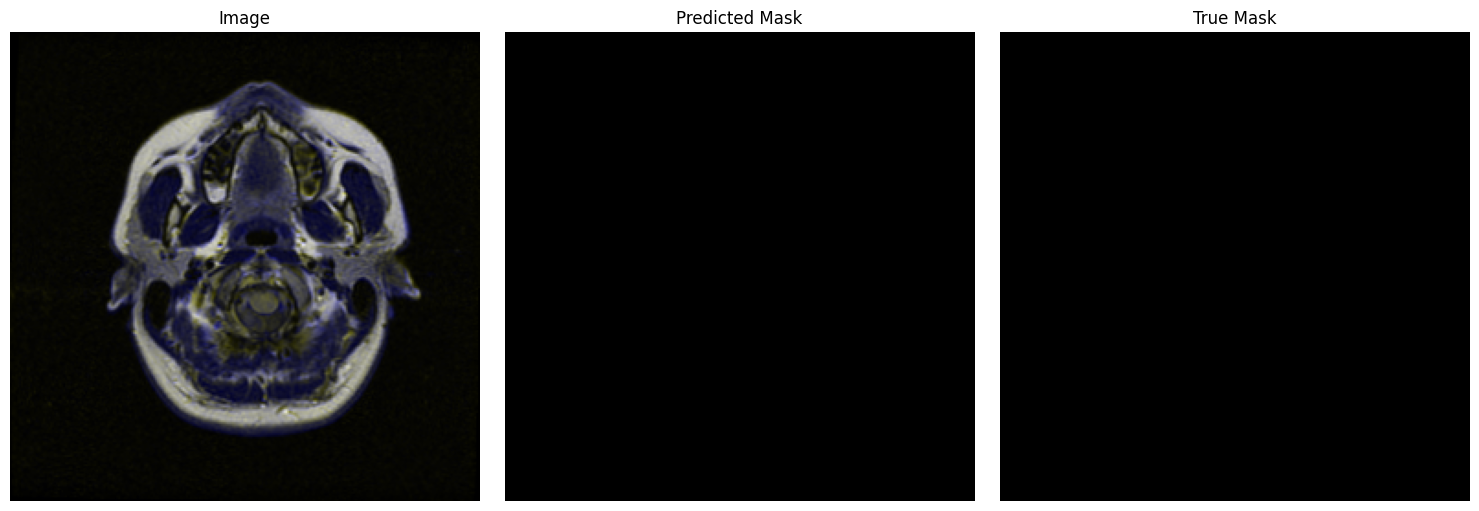

iou: 0.0
dice: nan


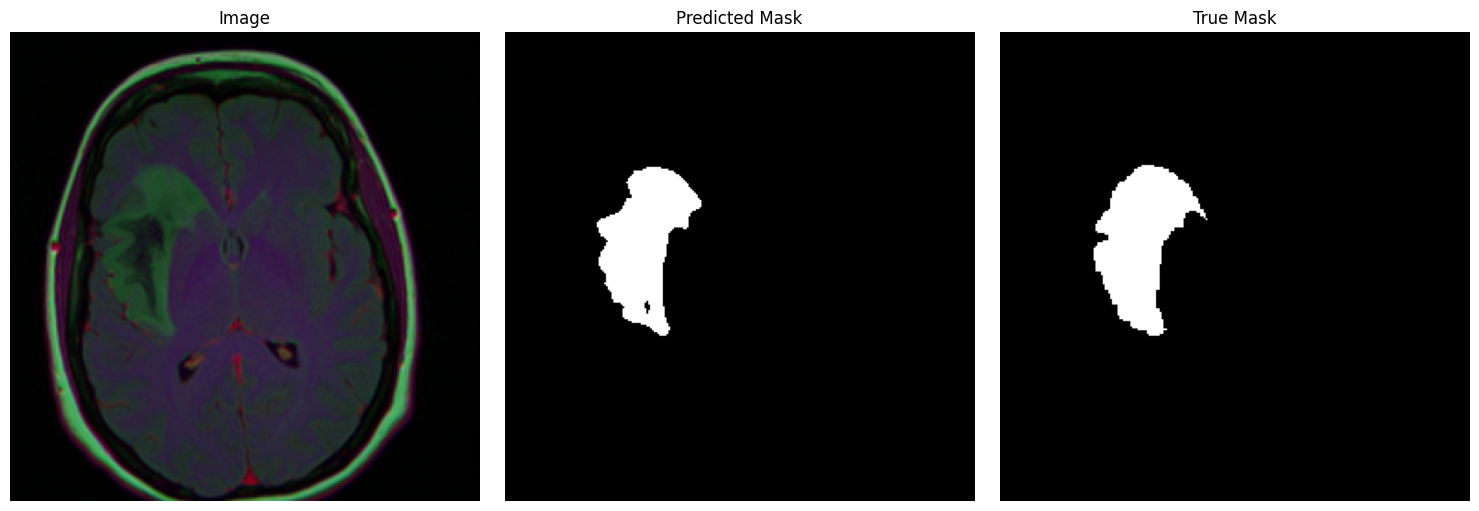

iou: 0.8836688995361328
dice: 0.9382422566413879
IOU: 0.675023187994957
Dice: 0.7944611746072769


In [66]:
total_iou = 0
total_dice_scrore = 0

ct = 0

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device).float(), labels.to(device).float()


        preds = model(imgs)
        preds = nn.functional.interpolate(preds, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        preds = (torch.sigmoid(preds) >= 0.5).to(torch.float32)

        # preds = model(imgs)
        # preds = torch.where(preds >= 0.5, 1., 0.)

        if (ct <= 2):
            for k in range(5):
                visualize_sample(imgs[k], preds[k], labels[k])
                iou = calculate_iou(preds[k], labels[k])
                print(f'iou: {iou}')
                dice_score = calculate_dice_score(preds[k], labels[k])
                print(f'dice: {dice_score}')
        ct += 1


        iou = calculate_iou(preds, labels)
        # print(f'iou: {iou}')
        total_iou += iou

        dice_score = calculate_dice_score(preds, labels)
        # print(f'dice: {dice_score}')
        total_dice_scrore += dice_score


test_iou = total_iou / len(test_dataloader)
test_dice_score = total_dice_scrore / len(test_dataloader)

print(f'IOU: {test_iou}')
print(f'Dice: {test_dice_score}')